In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications import VGG16
from keras import layers, models, optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.metrics import top_k_categorical_accuracy


In [2]:
# Define paths
base_dir = 'z3_data/'
train_dir = os.path.join(base_dir, 'train/')
test_dir = os.path.join(base_dir, 'test/')

In [3]:
image_size = (384, 384)
batch_size = 32
seed = 123

train_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.1,
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    subset='training',
    label_mode='categorical')

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(image_size),
    seed=seed,
    batch_size=batch_size,
    subset='validation',
    validation_split=0.1,
    label_mode='categorical')

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical')


Found 4860 files belonging to 90 classes.
Using 4374 files for training.
Found 4860 files belonging to 90 classes.
Using 486 files for validation.
Found 540 files belonging to 90 classes.


In [4]:
# Design the model
# model = models.Sequential()
# model.add(layers.Rescaling(1./255))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01), input_shape=(224, 224, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(90, activation='softmax'))

In [5]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D, Flatten, Dense

# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding='Same', activation ='relu', input_shape = (384, 384, 3), kernel_initializer='he_normal'))
# model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding='Same', activation ='relu',kernel_initializer='he_normal'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.2))
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
# model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.2))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
# model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
# model.add(Dense(90, activation = "softmax",kernel_initializer='he_normal'))

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu', input_shape = (384, 384, 3),strides = 3))
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu',strides = 3))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', kernel_regularizer=regularizers.L1L2(l1=0.005, l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(512, activation = "relu"))
model.add(Dense(1024, activation = "relu"))
# model.add(Dense(1024, activation = "relu"))
model.add(Dense(512, activation = "relu"))
model.add(Dense(90, activation = "softmax"))

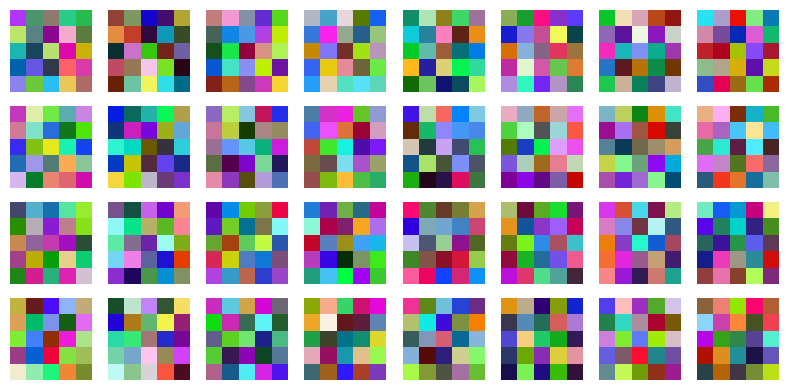

In [7]:
import matplotlib.pyplot as plt

def plot_conv_weights(model, layer_index, max_filters=32):
    # Extract weights
    weights = model.layers[layer_index].get_weights()[0]

    # Normalize the weights
    weights_min = weights.min()
    weights_max = weights.max()
    weights = (weights - weights_min) / (weights_max - weights_min)

    # Number of filters used in the conv. layer
    num_filters = min(weights.shape[3], max_filters)
    
    # Number of grid rows and columns
    grid_r, grid_c = -(-num_filters // 8), 8  # Ceiling division
    
    # Create a figure to display the filters
    fig, axes = plt.subplots(min(grid_r, 8), grid_c, figsize=(grid_c, grid_r))
    
    # Plot each filter
    filter_index = 0
    for r in range(min(grid_r, 8)):
        for c in range(grid_c):
            if filter_index < num_filters:
                ax = axes[r, c] if grid_r > 1 else axes[c]
                img = weights[:, :, :, filter_index]
                filter_index += 1
                ax.imshow(img.squeeze(), cmap='gray')
                ax.axis('off')
            else:
                axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the model and the index of the first conv layer
plot_conv_weights(model, 0)


In [8]:
def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
    metrics=['acc', top_2_accuracy, top_3_accuracy]
)


In [9]:
# Callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

In [10]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping_cb])

model.save("best_model2.tf")

Epoch 1/50
137/137 [==============================] - 26s 179ms/step - loss: 9.7834 - acc: 0.0094 - top_2_accuracy: 0.0167 - top_3_accuracy: 0.0283 - val_loss: 6.3633 - val_acc: 0.0062 - val_top_2_accuracy: 0.0103 - val_top_3_accuracy: 0.0206
Epoch 2/50
137/137 [==============================] - 23s 163ms/step - loss: 5.4898 - acc: 0.0149 - top_2_accuracy: 0.0267 - top_3_accuracy: 0.0402 - val_loss: 4.9491 - val_acc: 0.0062 - val_top_2_accuracy: 0.0267 - val_top_3_accuracy: 0.0329
Epoch 3/50
137/137 [==============================] - 23s 163ms/step - loss: 4.7390 - acc: 0.0135 - top_2_accuracy: 0.0263 - top_3_accuracy: 0.0425 - val_loss: 4.6135 - val_acc: 0.0144 - val_top_2_accuracy: 0.0391 - val_top_3_accuracy: 0.0473
Epoch 4/50
137/137 [==============================] - 23s 163ms/step - loss: 4.5424 - acc: 0.0123 - top_2_accuracy: 0.0327 - top_3_accuracy: 0.0498 - val_loss: 4.5037 - val_acc: 0.0185 - val_top_2_accuracy: 0.0412 - val_top_3_accuracy: 0.0556
Epoch 5/50
137/137 [========

INFO:tensorflow:Assets written to: best_model2.tf/assets


In [11]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
print(f"Train accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

137/137 [==============================] - 14s 98ms/step - loss: 3.7848 - acc: 0.0935 - top_2_accuracy: 0.1664 - top_3_accuracy: 0.2229


ValueError: too many values to unpack (expected 2)

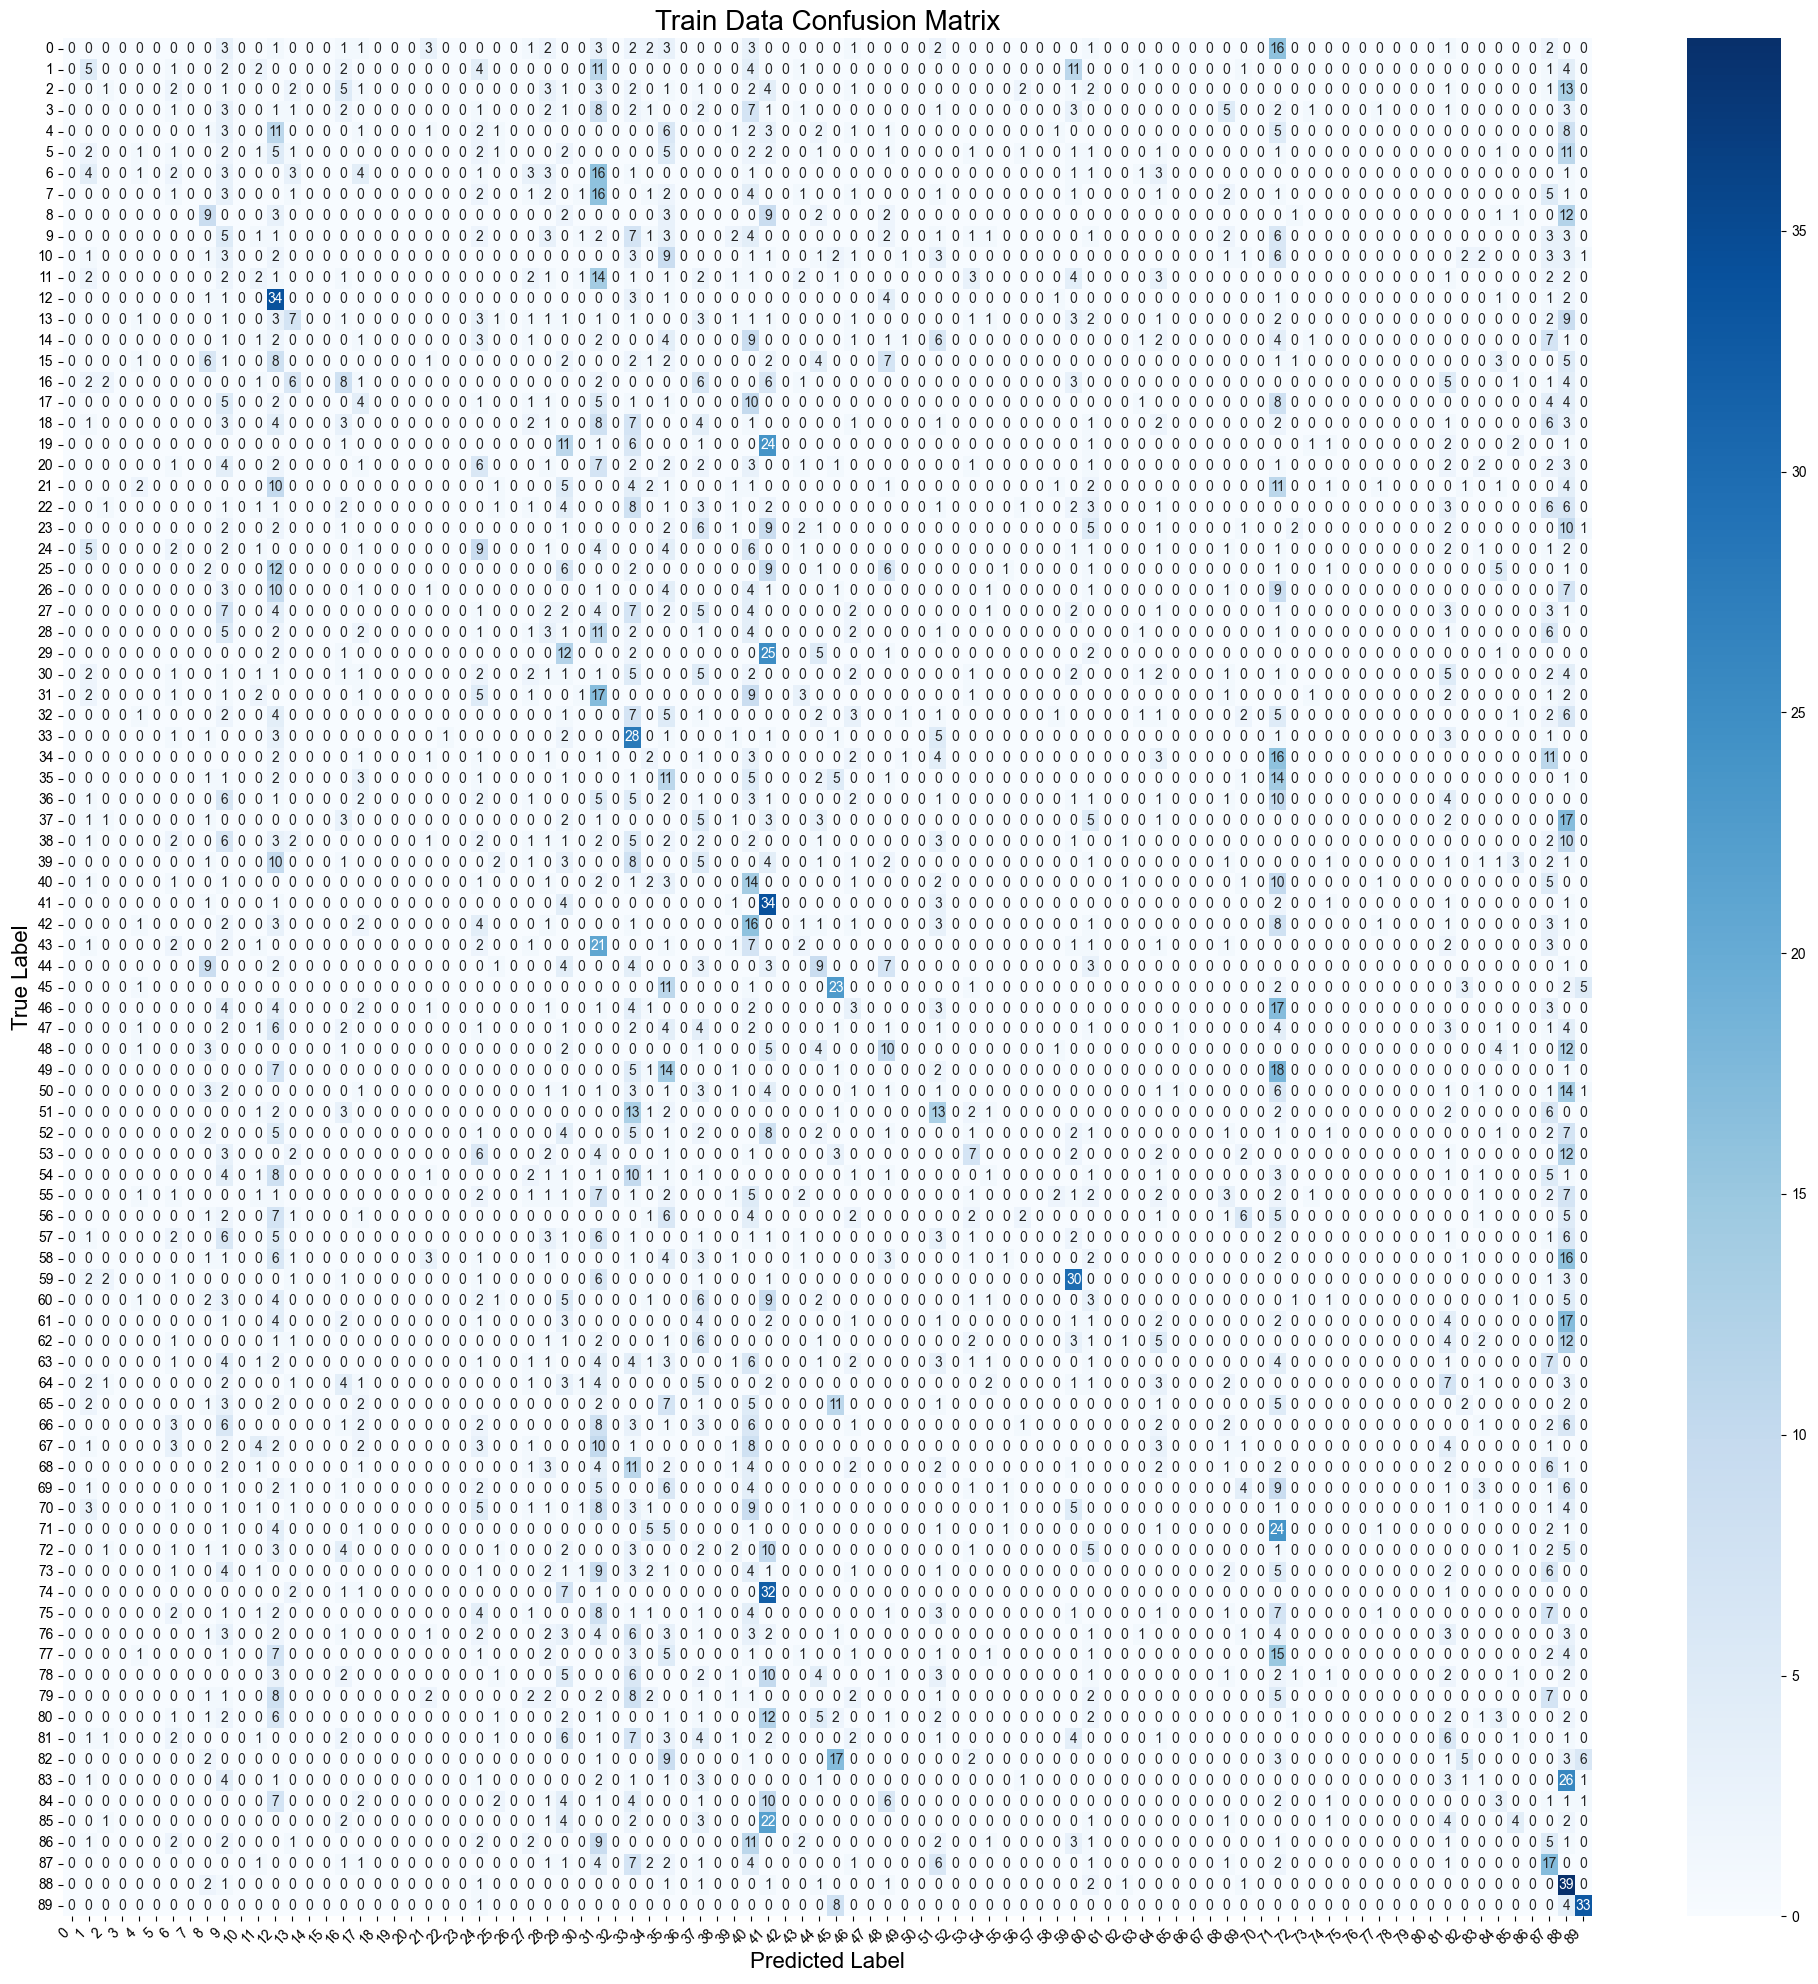

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Assuming model and train_ds (train dataset) are already defined

def get_predictions_train(model, dataset):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # iterate over the dataset
    for image_batch, label_batch in dataset:
        # convert one-hot labels to class indices, if necessary
        if label_batch.ndim > 1 and label_batch.shape[1] > 1:
            label_batch = np.argmax(label_batch, axis=1)
        y_true.append(label_batch)

        # compute predictions
        preds = model.predict(image_batch, verbose=0)
        # append predicted labels
        y_pred.append(np.argmax(preds, axis=-1))

    # convert the true and predicted labels into arrays
    y_true = np.concatenate(y_true)
    y_pred_classes = np.concatenate(y_pred)
    class_labels = list(range(90))

    return y_true, y_pred_classes, class_labels


# Get predictions and true labels
y_true, y_pred_classes, class_labels = get_predictions_train(model, train_generator)

# Create confusion matrix
confusion_mtx_train = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mtx_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
sns.set(font_scale=1)
plt.title('Train Data Confusion Matrix', size=20)
plt.xlabel('Predicted Label', size=16)
plt.ylabel('True Label', size=16)
plt.tight_layout()
plt.show()


17/17 [==============================] - 3s 140ms/step


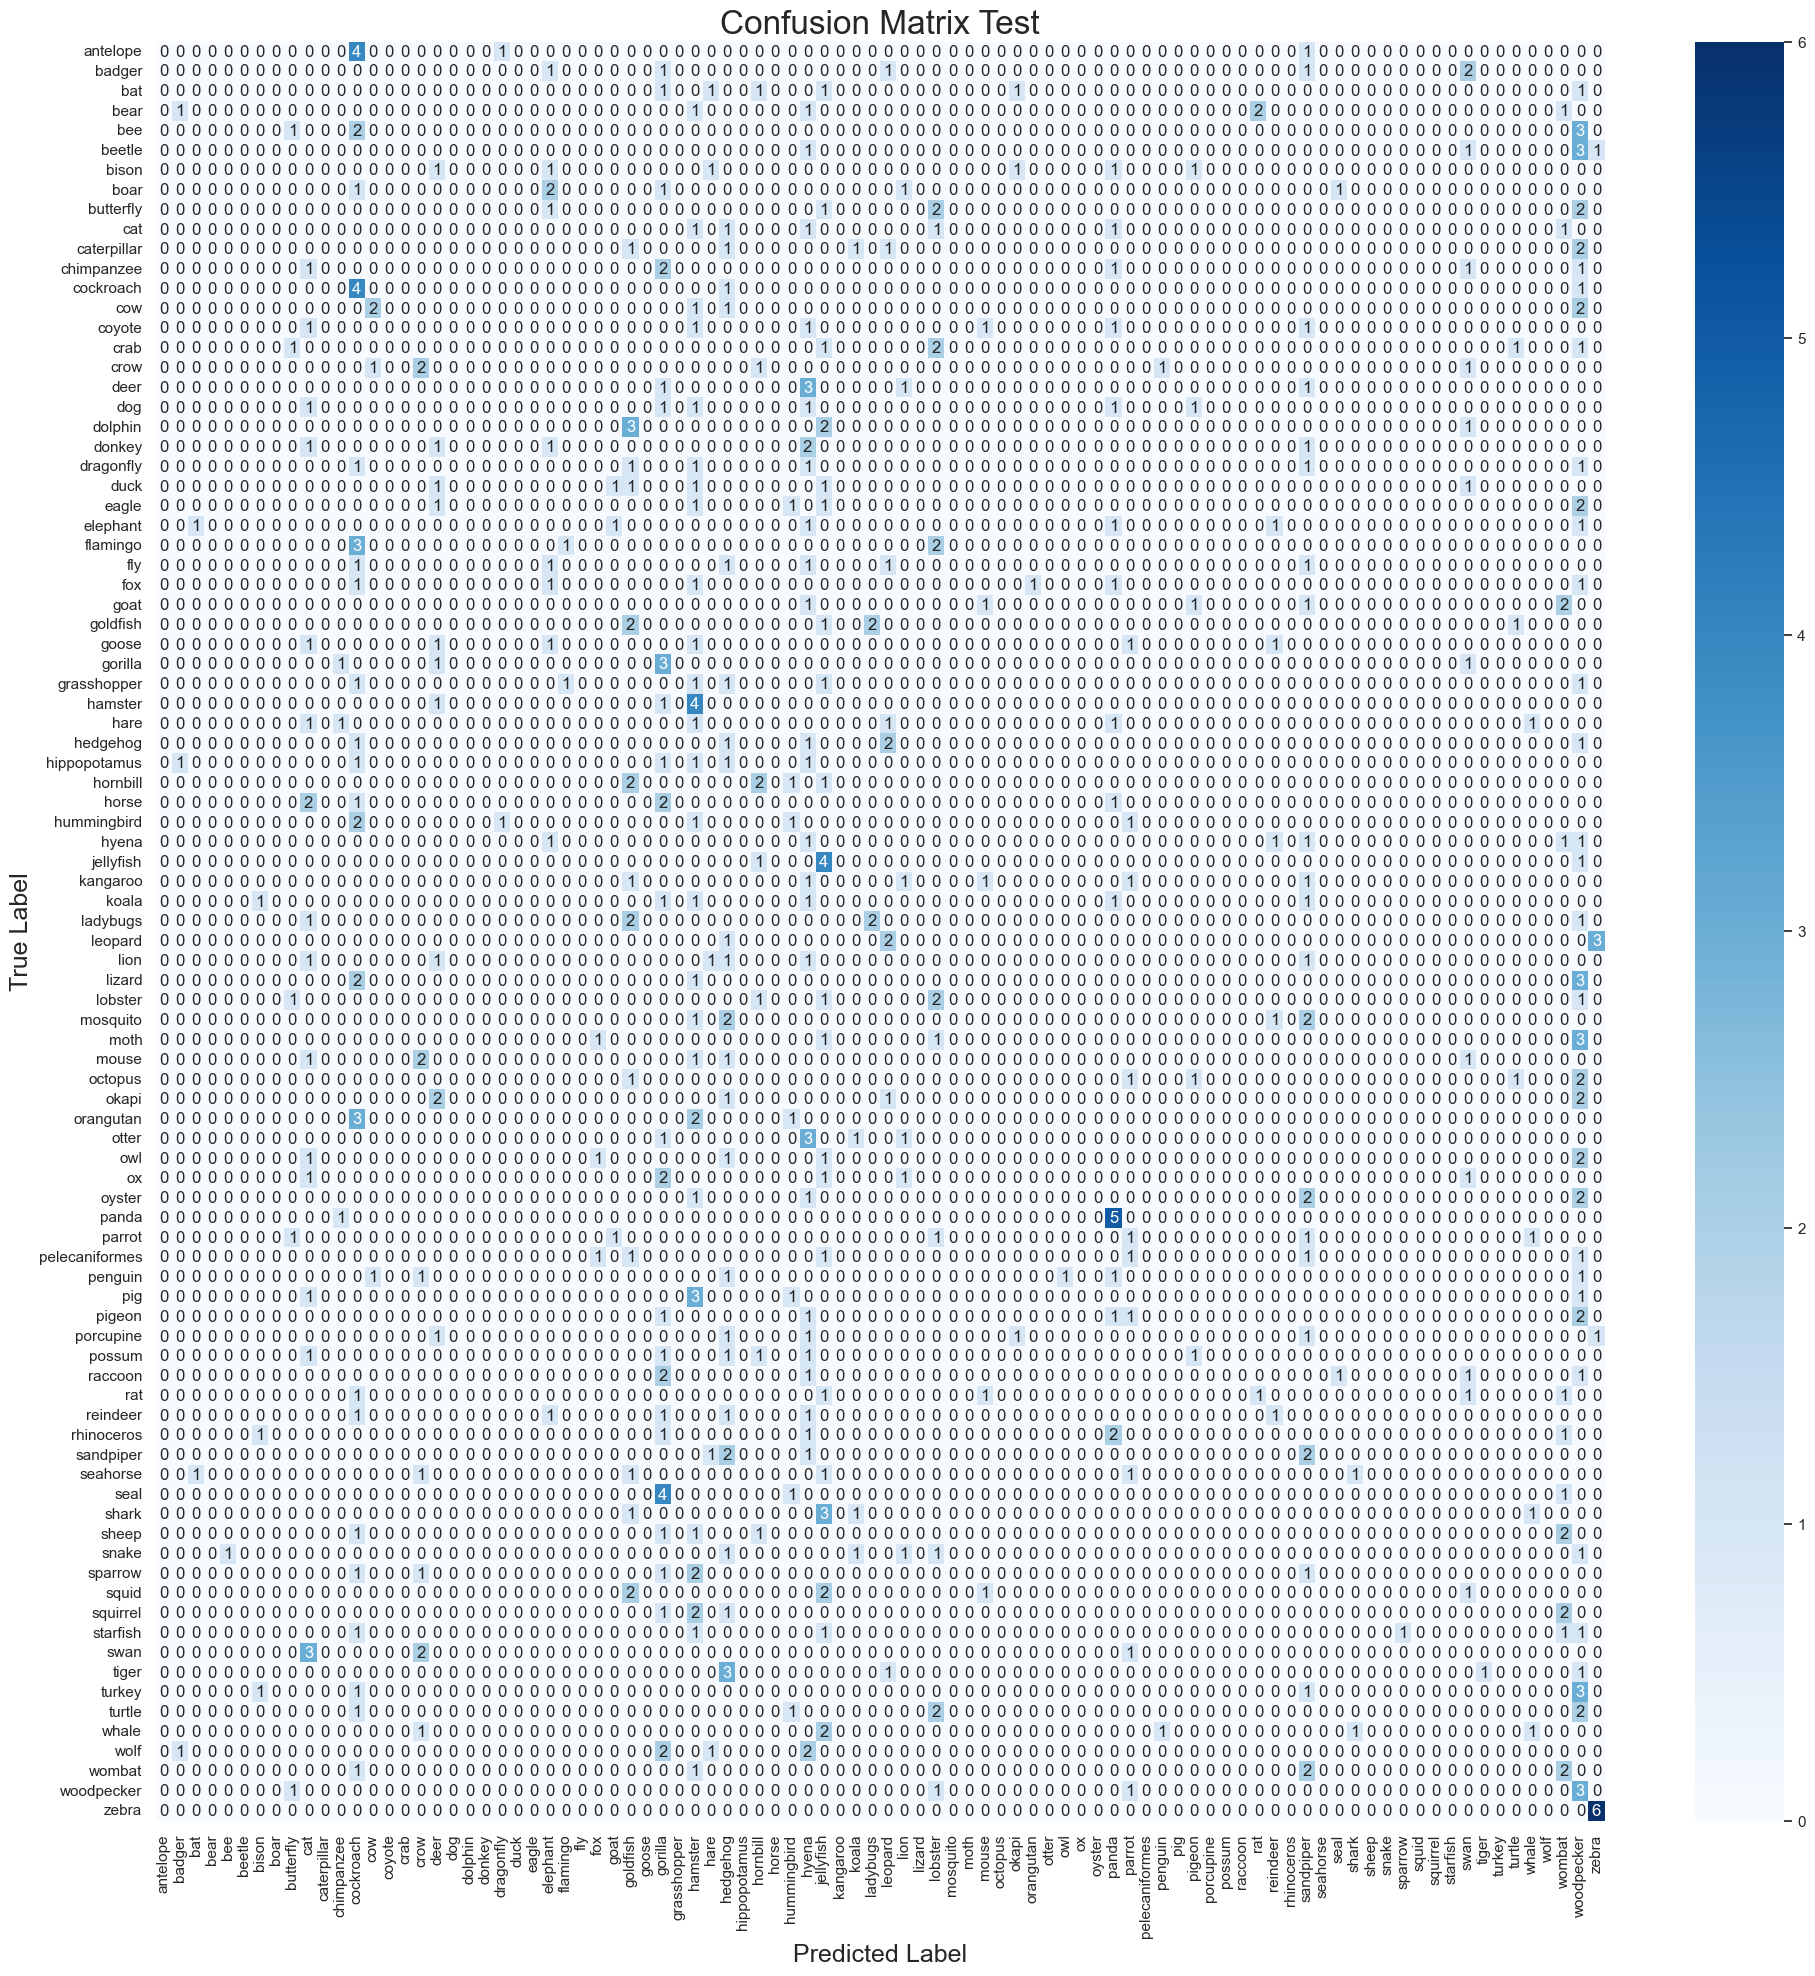

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the output
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Extract true classes from the test_generator
true_classes = []
for images, labels in test_generator:
    labels = np.argmax(labels, axis=1)  # Convert one-hot to indices
    true_classes.extend(labels)
true_classes = np.array(true_classes)

# Get class names directly from the generator
class_names = test_generator.class_names

# Map indices to class names
predicted_class_names = [class_names[i] for i in predicted_classes]
true_class_names = [class_names[i] for i in true_classes]

# Create the confusion matrix using sklearn
confusion_mtx_test = confusion_matrix(true_class_names, predicted_class_names)

# Assuming 'confusion_mtx' is already calculated and is a numpy array
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(20, 20))

# Create a heatmap from the confusion matrix
sns.heatmap(confusion_mtx_test, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)

# Rotate the x-axis labels to be vertical
plt.xticks(rotation=90)

# Rotate the y-axis labels to be horizontal
plt.yticks(rotation=0)

# Increase font size
sns.set(font_scale=1.2)

# Set the title and labels
plt.title('Confusion Matrix Test', size=24)
plt.xlabel('Predicted Label', size=18)
plt.ylabel('True Label', size=18)

# Adjust layout to make room for rotated x-axis labels
plt.tight_layout()

# Display the plot
plt.show()

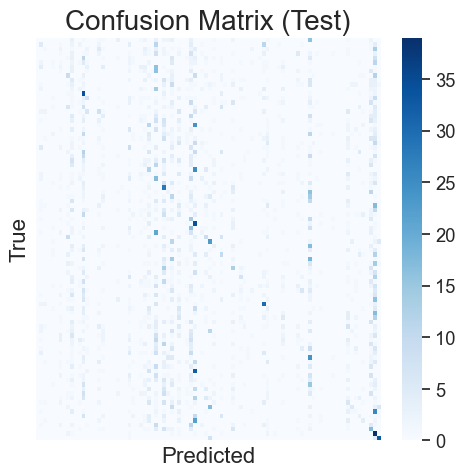

In [ ]:
import seaborn as sns

# Plotting the confusion matrix using seaborn for a neater appearance
plt.figure(figsize=(5, 5))  # Adjust the figure size as necessary
sns.heatmap(confusion_mtx_train, fmt='d', cmap='Blues')

# Remove the numbers from x-axis and y-axis
plt.xticks([])
plt.yticks([])

# Increase font size for readability
sns.set(font_scale=1.2)

# Set the title and labels with a larger font size
plt.title('Confusion Matrix (Test)', size=20)
plt.xlabel('Predicted', size=16)
plt.ylabel('True', size=16)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


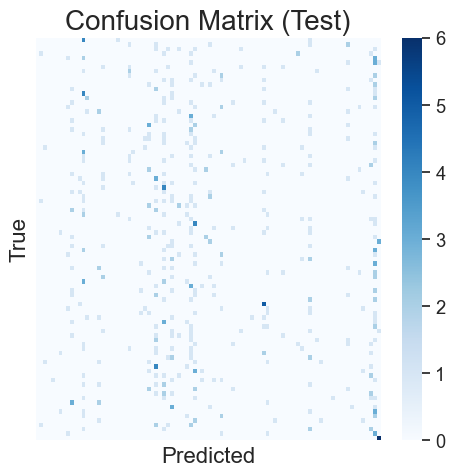

In [ ]:
import seaborn as sns

# Plotting the confusion matrix using seaborn for a neater appearance
plt.figure(figsize=(5, 5))  # Adjust the figure size as necessary
sns.heatmap(confusion_mtx_test, fmt='d', cmap='Blues')

# Remove the numbers from x-axis and y-axis
plt.xticks([])
plt.yticks([])

# Increase font size for readability
sns.set(font_scale=1.2)

# Set the title and labels with a larger font size
plt.title('Confusion Matrix (Test)', size=20)
plt.xlabel('Predicted', size=16)
plt.ylabel('True', size=16)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


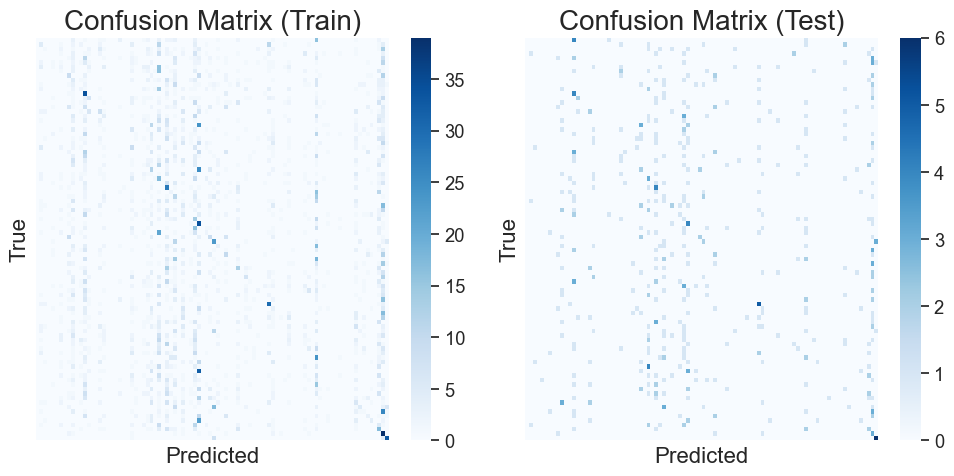

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall figure size
plt.figure(figsize=(10, 5))  # Adjust the overall figure size as necessary

# Plotting the train confusion matrix
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
sns.heatmap(confusion_mtx_train, fmt='d', cmap='Blues')
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.title('Confusion Matrix (Train)', size=20)  # Set title for the first matrix
plt.xlabel('Predicted', size=16)
plt.ylabel('True', size=16)

# Plotting the test confusion matrix
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
sns.heatmap(confusion_mtx_test, fmt='d', cmap='Blues')
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.title('Confusion Matrix (Test)', size=20)  # Set title for the second matrix
plt.xlabel('Predicted', size=16)
plt.ylabel('True', size=16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()


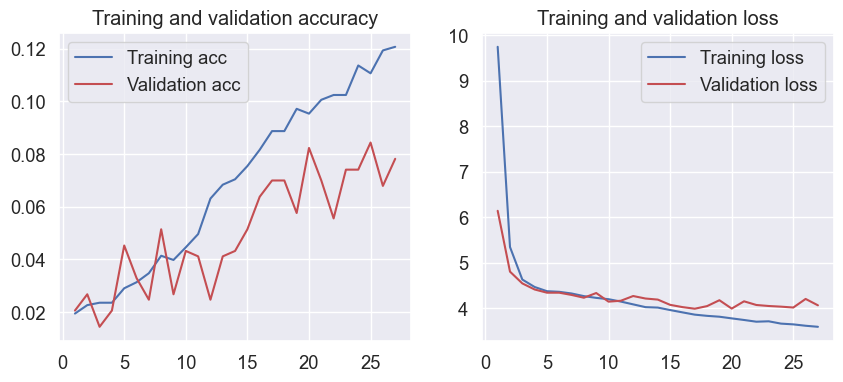

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()